In [ ]:
import torch
print(torch.__version__)
import torch.nn as nn
from torch.utils.data import TensorDataset,Dataset
from torch.utils.data import DataLoader
from torchsummary import summary
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

1.7.0+cu101


device(type='cuda')

In [ ]:
!pip install gputil
!pip install psutil
!pip install humanize

# Import packages
import os,sys,humanize,psutil,GPUtil
import gc

# Define function
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
  
  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))
    
# Execute function

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=10872de7b5034552a75f9fdbee30b5dd7172b61f3b2238872051b0b015b32ec6
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [ ]:
torch.cuda.empty_cache()
gc.collect()
mem_report()
!nvidia-smi

CPU RAM Free: 12.7 GB
GPU 0 ... Mem Free: 15069MB / 15079MB | Utilization   0%
Sun Nov 22 17:06:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
         

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
import sys
sys.path.append('/content/gdrive/My\ Drive')

In [ ]:
%load_ext autoreload
%autoreload 2

# IMPORTS

In [ ]:
import sys
sys.path.append('/content/gdrive/My\ Drive/ADJUST TO YOUR PATH/deep_learning/')
sys.path.append('/content/gdrive/My\ Drive/ADJUST TO YOUR PATH/deep_learning/dataloaders/')
sys.path.append('/content/gdrive/My\ Drive/ADJUST TO YOUR PATH/deep_learning/models/')
sys.path.append('/content/gdrive/My\ Drive/ADJUST TO YOUR PATH/deep_learning/training/')

import helpers_PPG2IABP

# Librerias
import scipy.io as sio
import pandas as pd
import json
import numpy as np
import itertools
import operator
import random
import os
import math
import copy


import dataloaders
import PPG2IABP
import simple_training_v5


#Plot
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import signal
from scipy.fft import fft
from scipy.stats import norm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

In [ ]:
folders_dict={}
version = 'Mix_no_CI'

zip_path ="/content/gdrive/My\ Drive/ADJUST TO YOUR PATH/datasets/"
df_path = "/content/gdrive/My\ Drive/ADJUST TO YOUR PATH/df_filtered/"
plot_path = "/content/gdrive/My\ Drive/ADJUST TO YOUR PATH//"+version+"/figures/"

folders_dict['ABP_PPG'] = {'zip_path':zip_path+"ABP_PPG.zip",
                           'df_path':df_path+"ABP_PPG/"}

df_files = {}
df_files['sex_age'] = 'df_filtered_signals_icu_hadm_sex_age.csv'

In [ ]:
dataset = "ABP_PPG"
df_file_name = 'sex_age'
zip_adress = folders_dict[dataset]['zip_path']
zip_name = zip_adress[len(zip_path):]
signals_path = '/content/gdrive/My\ Drive/ADJUST TO YOUR PATH/dataset/'
df_path = folders_dict[dataset]['df_path']

In [ ]:
!rm -rf /content/dataset

In [ ]:
!cp -r $zip_adress /content/
!mkdir /content/dataset
!unzip $zip_name -d /content/dataset
!rm $zip_name

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/ABP_PPG/3443003_0009.mat  
  inflating: /content/dataset/ABP_PPG/3443003_0013.mat  
  inflating: /content/dataset/ABP_PPG/3985608_0007.mat  
  inflating: /content/dataset/ABP_PPG/3985608_0009.mat  
  inflating: /content/dataset/ABP_PPG/3985608_0011.mat  
  inflating: /content/dataset/ABP_PPG/3185249_0007.mat  
  inflating: /content/dataset/ABP_PPG/3185249_0025.mat  
  inflating: /content/dataset/ABP_PPG/3809776_0010.mat  
  inflating: /content/dataset/ABP_PPG/3879059_0004.mat  
  inflating: /content/dataset/ABP_PPG/3879059_0006.mat  
  inflating: /content/dataset/ABP_PPG/3581834_0032.mat  
  inflating: /content/dataset/ABP_PPG/3581834_0027.mat  
  inflating: /content/dataset/ABP_PPG/3581834_0030.mat  
  inflating: /content/dataset/ABP_PPG/3581834_0035.mat  
  inflating: /content/dataset/ABP_PPG/3581834_0065.mat  
  inflating: /content/dataset/ABP_PPG/3581834_0073.mat  
  inflating: /content/dataset/ABP_PPG

In [ ]:
"""%cd /content/dataset/
!zip -r ABP_PPG.zip ABP_PPG"""

In [ ]:
signals_path = signals_path + dataset + '/'
completed = helpers_PPG2IABP.loadmat(signals_path+'completed')
completed = completed['completed']

sum_cycles = 0
sum_f = 0
sum_p = 0
sum_fe = 0
sum_ppg = 0
sum_abp = 0

n_total_files = np.size(completed)

for i in np.arange(0,n_total_files):
    #if completed[i].status ==1:
    sum_cycles = sum_cycles + completed[i].count_cycles
    sum_f = sum_f + completed[i].count_f
    sum_p = sum_p + completed[i].count_p
    sum_fe = sum_fe + completed[i].count_fe
    sum_ppg = sum_ppg + completed[i].count_fe_ppg
    sum_abp = sum_abp + completed[i].count_fe_abp

# Processing Results: Causes of fail

In [ ]:
per_sum_f = np.round((sum_f / sum_cycles)*100,2)
per_sum_p = np.round((sum_p / sum_cycles)*100,2)
per_fe = np.round((sum_fe / sum_cycles)*100,2)
per_ppg = np.round((sum_ppg / sum_fe)*100,2)
per_abp = np.round((sum_abp / sum_fe)*100,2)

print(f' Flat: {per_sum_f}% \r\n Peaks: {per_sum_p}% \r\n F.Extraction: {per_fe}% ( PPG: {per_ppg}% | ABP:{per_abp}% ) \r\n')

 Flat: 15.57% 
 Peaks: 58.78% 
 F.Extraction: 25.65% ( PPG: 98.12% | ABP:1.88% ) 



### Signals DB

In [ ]:
from os import listdir
from os.path import isfile, join
#list of all files in 'signals_path'
files_processed = [f for f in listdir(signals_path) if isfile(join(signals_path, f))]
files_processed.sort()
files_processed = files_processed[:-2] # to eliminate 'completed.mat'
files_processed = [x[:-4] for x in files_processed]
np.shape(files_processed)

(5854,)

# 2) PPG --> Mean_Pulse

# Parameters

In [ ]:
#Load file example
file = helpers_PPG2IABP.loadmat(signals_path+files_processed[0])
file = file['signal_processing']
with open(df_path+'parametros.json') as json_file:
    parametros = json.load(json_file)
    
    
# Parameters
fs = parametros['fs']
q_files_processed = np.shape(files_processed)[0] #Qty of files
q_signals_file = parametros['q_signal'] #np.shape(file)[0] )
channels_selected = parametros['channels_selected']
q_channels = len(channels_selected)
channels_selected = {k: v for v, k in enumerate(channels_selected)}

if q_channels > 1:
  len_signal = np.shape(file[0].signal[0])[0] # Length of each signal
else:
  len_signal = np.shape(file[0].signal)[0] # Length of each signal
DBP_low = parametros['DBP_low']
ppg_margin = 20 # from matlab code "make_matrices.m", #line 106 and 107

print(f' q_files_ok: {q_files_processed}\r\n q_signals: {q_signals_file} [Qty of signals/file]\r\n q_channels: {q_channels}\r\n len_signal: {len_signal}\r\n')

 q_files_ok: 5854
 q_signals: 2 [Qty of signals/file]
 q_channels: 2
 len_signal: 1876



### Clinical DB

In [ ]:
df_o = pd.read_csv(df_path+df_files[df_file_name],index_col=0)
df_o.isnull().values.any()

False

In [ ]:
df_o = df_o[df_o['subrecord'].isin(files_processed)]
files_ok = df_o['subrecord'].values.tolist()
q_files = df_o.shape[0]
print(f'Cantidad de Registros: {q_files}')
print('Cantidad de Sujetos: {}'.format(np.shape(df_o['subject_id'].unique())[0]))

Cantidad de Registros: 5521
Cantidad de Sujetos: 1133


In [ ]:
fs = 125
window_training = 5 #seconds
max_n_records = 5 
q_signals_file = 2
all_plots = False

t_size = 0.20
r_seed = np.random.randint(0)

sbp_threshold = 180
duration_threshold = 150
skew_threshold = 0.2

post_beat_max = 15
penalize_max_t = 15 # How many values penalize after the end of the beat

#butter filter
lowcut = 0.5
highcut = 45
order = 5

#Savitzky-Golay filter
window = 7
ploy_grade = 3
s_mode ='mirror'
dx_n = 1
mixed = False

In [ ]:
x_train,x_test,y_train,y_test,y_mask_train,y_mask_test,\
y_values_bp_train,y_values_bp_test,y_idx_bp_train,y_idx_bp_test,\
X_ci_train_scaled,X_ci_test_scaled, df_train, df_test,\
q_train,q_test,final_len_x,final_len_y,diff_window_ppg,scaler_P = helpers_PPG2IABP.func_x_y_sets(df_o,df_file_name,q_files,len_signal,channels_selected,
                                                                  fs,window_training,max_n_records,
                                                                  q_signals_file,t_size,r_seed,
                                                                  sbp_threshold,duration_threshold,skew_threshold,
                                                                  post_beat_max,penalize_max_t,
                                                                  lowcut,highcut,order,
                                                                  window,ploy_grade,s_mode,dx_n,
                                                                  mixed,signals_path,all_plots=False)

# DATALOADER

In [ ]:
#Sets
bs = 48
test_bs = 48
test_ds = dataloaders.Dataset_V5(x_test, X_ci_test_scaled,y_test,y_mask_test,final_len_x,diff_window_ppg,device)
test_dl = DataLoader(test_ds, batch_size=test_bs, shuffle=False)

test_dl_predict = DataLoader(test_ds, batch_size=1, shuffle=False) 

train_final_ds = dataloaders.Dataset_V5(x_train,X_ci_train_scaled,y_train,y_mask_train,final_len_x,diff_window_ppg,device)
train_final_dl = DataLoader(train_final_ds, batch_size=bs, shuffle=True)

# Definirions

In [ ]:
path_save = "/content/gdrive/My\ Drive/ADJUST TO YOUR PATH/"+version+"/save/"
model_name = version+".pt"
model_save = path_save + model_name

In [ ]:
hidden_size = 4

encoder_ci = False
input_size_ci = np.shape(X_ci_test_scaled)[1]
if encoder_ci:
  input_size_encoder = 1 + 1 + input_size_ci # por que incluyo el canal de la derivada
else:
  input_size_encoder = 1 + 1  # por que incluyo el canal de la derivada
 
input_size_decoder = 1 + 4  # signal + label
 
output_size_signal = 1
output_size_segment = 4
bidirectional_enc = True
 
dropout = 0.015
method='general'

In [ ]:
def seed_torch(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
 
seed_torch(r_seed)
 
encoder = PPG2IABP.Encoder(input_size_encoder, hidden_size, bidirectional_enc).to(device)
 
decoder = PPG2IABP.Decoder(input_size_decoder,input_size_encoder,input_size_ci, hidden_size,
                  output_size_signal,output_size_segment,
                  bidirectional_enc,dropout,method).to(device)
                  
model = PPG2IABP.Modelo(encoder, decoder,device).to(device)

In [ ]:
print(f'The model has {helpers_PPG2IABP.count_parameters(model):,} trainable parameters')

In [ ]:
criterion_signal = nn.MSELoss(reduction='none')
criterion_label = nn.NLLLoss()

weight_label = 0.01

l_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=l_rate)#,weight_decay=0.4)
patience_lim = 20
sch_scale = 0.5
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=patience_lim,factor=sch_scale,verbose=True)

In [ ]:
torch.cuda.empty_cache()
gc.collect()
mem_report()

# TRAINING

In [ ]:
N_EPOCHS = 300
clip_val = 3

model, history = simple_training_v5.fit(N_EPOCHS,model,optimizer,scheduler,criterion_signal,criterion_label,
         weight_label,clip_val,train_final_dl,q_train,test_dl,q_test,final_len_y,model_save,save=True,final=True)
np.savez(model_save[:-3]+'_history_test_final',history)

In [ ]:
model,optimizer,scheduler,epoch_i,best_valid_loss,loss_train_history,loss_val_history = simple_training_v5.load_checkpoint(model,optimizer,scheduler,model_save,stage='final')

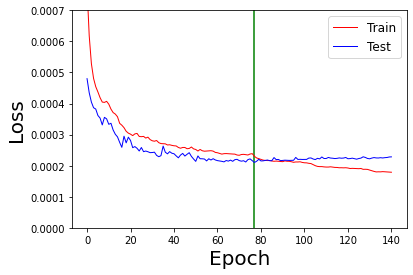

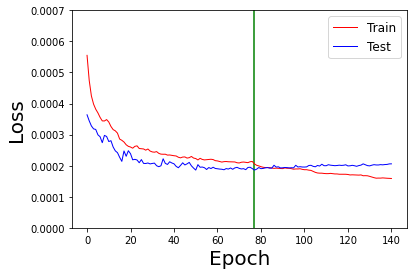

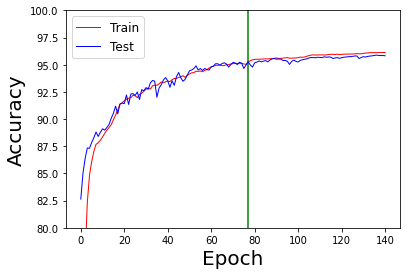

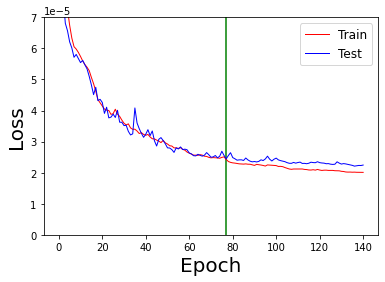

In [ ]:
factor = 0.5
history_full = np.load(model_save[:-3]+'_history_test_final.npz',allow_pickle=True)
train_history_full = history_full['arr_0'][0]
val_history_full = history_full['arr_0'][1]
 
 
#Total
init_e = 0
plt.plot(helpers_PPG2IABP.smooth_curve(train_history_full[0][init_e:], factor),label='Train',lw=1,c='r')
plt.plot(helpers_PPG2IABP.smooth_curve(val_history_full[0][init_e:],factor),label='Test',lw=1, c='b')
plt.vlines(x=epoch_i,ymin=0,ymax=1,colors='green')
plt.ylim((0,0.0007))
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.legend(fontsize='large')
plot_name = str(plot_path+'Total_Losses')
#plt.savefig(plot_name+".eps",bbox_inches = "tight")
plt.show()
#Signal Loss
plt.plot(helpers_PPG2IABP.smooth_curve(train_history_full[1][init_e:], factor),label='Train',lw=1,c='r')
plt.plot(helpers_PPG2IABP.smooth_curve(val_history_full[1][init_e:],factor),label='Test',lw=1, c='b')
plt.vlines(x=epoch_i,ymin=0,ymax=1,colors='green')
plt.ylim((0,0.0007))
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.legend(fontsize='large')
plot_name = str(plot_path+'Signal_Losses')
#plt.savefig(plot_name+".eps",bbox_inches = "tight")
plt.show()
#Acc
plt.plot(helpers_PPG2IABP.smooth_curve(train_history_full[3][init_e:], factor),label='Train',lw=1,c='r')
plt.plot(helpers_PPG2IABP.smooth_curve(val_history_full[3][init_e:],factor),label='Test',lw=1, c='b')
plt.vlines(x=epoch_i,ymin=0,ymax=100,colors='green')
plt.ylim((80,100))
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.legend(fontsize='large')
plot_name = str(plot_path+'Accuracy')
#plt.savefig(plot_name+".eps",bbox_inches = "tight")
plt.show()
#Label Loss
plt.plot(helpers_PPG2IABP.smooth_curve(train_history_full[2][init_e:], factor),label='Train',lw=1,c='r')
plt.plot(helpers_PPG2IABP.smooth_curve(val_history_full[2][init_e:],factor),label='Test',lw=1, c='b')
plt.vlines(x=epoch_i,ymin=0,ymax=1,colors='green')
plt.ylim((0,0.00007))
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.legend(fontsize='large')
plot_name = str(plot_path+'Label_Losses')
#plt.savefig(plot_name+".eps",bbox_inches = "tight")
plt.show()

In [ ]:
total_test_loss,signal_test_loss,label_test_loss, test_accuracy = simple_training_v5.evaluate(model, test_dl, criterion_signal,criterion_label, weight_label,q_test,final_len_y)
total_train_loss = train_history_full[0][epoch_i]
signal_train_loss = train_history_full[1][epoch_i]
label_train_loss = train_history_full[2][epoch_i]
train_accuracy =train_history_full[3][epoch_i]
print('\tTTrain_Loss: {:.8f}\tSTrain_Loss: {:.8f}\tLTrain_Loss: {:.8f}\tAcc_Train: {:.8f}'.format(total_train_loss,signal_train_loss,label_train_loss,train_accuracy))
print('\tTT_Loss: {:.8f}\tST_Loss: {:.8f}\tLT_Loss: {:.8f}\tAcc_Test: {:.8f}'.format(total_test_loss,signal_test_loss,label_test_loss, test_accuracy))

	TTrain_Loss: 0.00022155	STrain_Loss: 0.00019815	LTrain_Loss: 0.00002340	Acc_Train: 95.43662976
	TT_Loss: 0.00020421	ST_Loss: 0.00018067	LT_Loss: 0.00002354	Acc_Test: 95.54516093


# TEST

In [ ]:
x_test_mod, predictions, TT_Loss,ST_Loss,LT_Loss,Acc_Test,attentions = simple_training_v5.predict(model,test_dl,criterion_signal,criterion_label,
                                                                                         weight_label,final_len_x,final_len_y)
 
if torch.cuda.is_available():
  predictions = predictions.to(torch.device("cpu"))
  x_test_mod = x_test_mod.to(torch.device("cpu"))
  attentions = attentions.to(torch.device("cpu"))
 
predictions = predictions.detach().numpy()
x_test_mod = x_test_mod.detach().numpy()
attentions = attentions.detach().numpy()

In [ ]:
print(TT_Loss,ST_Loss,LT_Loss,Acc_Test)

0.00019319531980184682 0.00016981874691121156 2.337657289063527e-05 95.57300367524223


In [ ]:
x_test_mod = np.swapaxes(x_test_mod,1,2)

In [ ]:
sgn = np.random.randint(0,high=q_test)
input = x_test_mod[sgn,0:2,:] # PPG Y dPPG

y_label_pred = np.argmax(predictions[sgn,:,1:5],axis=1)
end_pred = np.where(y_label_pred==0)[0]
#end_pred = [157]

if np.shape(end_pred)[0] != 0:
  end_pred = end_pred[0]
  y_pred = predictions[sgn,:end_pred,0]
  attention_weights = attentions[sgn,:,:end_pred]
else:
  y_pred = predictions[sgn,:,0]
  attention_weights = attentions[sgn]

y_bp_sys = y_pred.max()
y_bp_dias = np.mean([y_pred[0],y_pred[-1]])
y_bp = [y_bp_sys,y_bp_dias]

cmap = 'jet'
y_true = y_test[sgn,0,:]
#y_true = predictions[sgn+20,:,0]

fig1,ax1,ax2,ax3 = helpers_PPG2IABP.plot_attention(input,y_pred,attention_weights,y_true,y_label_pred,cmap)
ax1.set_ylim((0,1.25))
#ax1.hlines(y_bp[0],xmin=0,xmax=final_len_y,color='m',linestyle='dashed')
#ax1.hlines(y_bp[1],xmin=0,xmax=final_len_y,color='m',linestyle='dashed')
#plot_name = str(plot_path+'Attention_output'+".eps")
#plt.savefig(plot_name, dpi=300,bbox_inches = "tight")#,rasterized=True)
plt.show()

# CONTINUE TRAINING

In [ ]:
model,optimizer,scheduler,epoch_i,best_valid_loss,loss_train_history,loss_val_history = simple_training_v5.load_checkpoint(model,optimizer,scheduler,model_save,'final')
history = np.asarray([loss_train_history,loss_val_history])

In [ ]:
N_EPOCHS = 500 - epoch_i
clip_val = 3
model,history = simple_training_v5.fit(N_EPOCHS,model,optimizer,scheduler,criterion_signal,criterion_label,
         weight_label,clip_val,train_final_dl,q_train,test_dl,q_test,final_len_y,model_save,save=True,final=True,
         e_i = epoch_i, history=history)
np.savez(model_save[:-3]+'_history_test_final',history)